### Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import collections
import nltk

from rdflib import Graph
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from openpyxl import Workbook

### Load Data

In [2]:
df = pd.read_csv('Data/data.csv',sep=";")
display(df.head())

,uri,date,claim,keywords,organization,rating
0,http://data.gesis.org/claimskg/creative_work/9...,03/26/2055,California’s Prop 55 'prevents $4 billion in n...,"education,state finances",politifact,MIXTURE
1,http://data.gesis.org/claimskg/creative_work/e...,03/26/2020,Says an election clerk in Green Bay refused to...,"bipartisanship,city government,education,elect...",politifact,MIXTURE
2,http://data.gesis.org/claimskg/creative_work/d...,12/10/2019,'Queen Elizabeth removes Obamas from royal wed...,fake news,politifact,FALSE
3,http://data.gesis.org/claimskg/creative_work/0...,12/03/2019,Says state schools superintendent candidate Do...,"corporations,education,small business,state bu...",politifact,MIXTURE
4,http://data.gesis.org/claimskg/creative_work/f...,11/27/2019,"'The Walton family, which owns Wal-Mart, contr...","corporations,economy,income,labor,wealth",politifact,TRUE


### Get Vocabulary

In [3]:
keywordDict = dict()
for index, row in df.iterrows():
    keywords = [x.strip() for x in row.keywords.split(',')]
    for keyword in keywords:
        if keyword in keywordDict:
            keywordDict[keyword] += 1
        else:
            keywordDict[keyword] = 1

print("There's a total of %d keywords after lemmatizing" % len(keywordDict))

There's a total of 8883 keywords after lemmatizing


In [4]:
#Sort dict by occurrences
sorted_dict = sorted(keywordDict.items(), key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_dict)

n_occurrences = 50

#Keep keywords with n or more ocurrences
for key in list(sorted_dict):
    if sorted_dict[key] < n_occurrences:
        del sorted_dict[key]

keywordList = list(sorted_dict)
print("There's a total of %d keywords after removing keywords that occur in less than %d claims" % (len(sorted_dict),n_occurrences))

There's a total of 159 keywords after removing keywords that occur in less than 50 claims


In [5]:
for key, value in sorted_dict.items():
    print("%s: %d" % (key,value))

tourism: 50
reader suggestion: 50
space: 51
sona: 51
employment: 51
melania trump: 52
statistic: 52
ebola: 53
satire: 53
trump: 53
gun: 53
fact check: 53
recreation: 54
cpc: 54
russia: 54
alcohol: 55
woman: 55
message machine 2014: 56
racism: 57
the last line of defense: 58
america 's last line of defense: 59
your news wire: 59
gun control: 59
election: 59
pensions: 60
conspiracy theory: 60
fauxtography: 62
jacob zuma: 62
state government spending: 63
president trump: 63
something for nothing: 63
weather: 64
oil spill: 65
television: 66
pop culture: 67
afghanistan: 67
crusader habit: 67
radio & tv: 68
animals: 69
county budget: 71
israel: 74
county government: 76
human rights: 77
new hampshire 2012: 77
marriage: 77
bernie sander: 77
viral video: 77
debates: 81
sexuality: 82
natural phenomena: 82
music: 84
development: 86
wealth: 88
congressional rules: 88
population: 88
infrastructure: 91
hoax: 91
movies: 91
china: 93
florida: 96
welfare: 97
world news daily report: 101
muslim: 101
sma

In [6]:
def get_keyword_provenance(sorted_dict):
    organization_dict = dict.fromkeys(sorted_dict)
    for index, row in df.iterrows():
        keywords = [x.strip() for x in row.keywords.split(',')]
        author = row.organization
        for keyword in keywords:
            if keyword in organization_dict:
                if organization_dict[keyword] == None:
                    organization_dict[keyword] = author
                else:
                    if organization_dict[keyword].find(author) == -1:
                        organization_dict[keyword] += ', ' + author
    return organization_dict

In [7]:
organization_dict = get_keyword_provenance(sorted_dict)

for key, value in organization_dict.items():
    print("%s: %s" % (key,value))

tourism: politifact, snopes, africacheck
reader suggestion: africacheck
space: politifact, snopes
sona: africacheck
employment: africacheck
melania trump: snopes
statistic: africacheck
ebola: politifact, snopes, africacheck
satire: snopes
trump: snopes
gun: snopes, africacheck
fact check: snopes
recreation: politifact
cpc: factscan
russia: snopes
alcohol: politifact, snopes, africacheck
woman: snopes, africacheck
message machine 2014: politifact
racism: snopes
the last line of defense: snopes
america 's last line of defense: snopes
your news wire: snopes
gun control: snopes
election: snopes, factscan, africacheck
pensions: politifact
conspiracy theory: snopes
fauxtography: snopes
jacob zuma: africacheck, snopes
state government spending: politifact
president trump: snopes
something for nothing: snopes
weather: politifact, snopes
oil spill: politifact
television: snopes
pop culture: politifact
afghanistan: politifact, snopes
crusader habit: snopes
radio & tv: snopes
animals: politifact


In [8]:
wb = Workbook()
sheet1 = wb['Sheet']
wb.remove(sheet1)

ws = wb.create_sheet("Keywords")
ws.append(["Keyword", "Occurrences", "Sites"])

#Save keywords to excel
for key in sorted_dict:
    row = [key,sorted_dict[key],organization_dict[key]]
    ws.append(row)
    
#Save Excel File
wb.save("Data/Keywords.xlsx")

### Get entities by keyword

In [9]:
df2 = pd.read_csv('Data/claims_keywords_entities.csv',sep=";")
display(df2.head())

,uri,keywords,entity
0,http://data.gesis.org/claimskg/creative_work/0...,"consumer safety,energy,job accomplishments",Texas Department of Agriculture
1,http://data.gesis.org/claimskg/creative_work/0...,"military,veterans",John McCain
2,http://data.gesis.org/claimskg/creative_work/0...,"military,veterans",Donald Trump
3,http://data.gesis.org/claimskg/creative_work/0...,"big pharma,vaccine",Judy Mikovits
4,http://data.gesis.org/claimskg/creative_work/0...,"families,government regulation,health care,pub...",pregnancy


In [10]:
entities_dict = dict.fromkeys(sorted_dict)

for index, row in df2.iterrows():
    keywords = [x.strip() for x in row.keywords.split(',')]
    for keyword in keywords:
        if keyword in entities_dict:
            if entities_dict[keyword] == None:
                entities_dict[keyword] = list()
                entities_dict[keyword].append(row.entity)
            else:
                if row.entity not in entities_dict[keyword]:
                    entities_dict[keyword].append(row.entity)

In [11]:
wb = Workbook()
sheet1 = wb['Sheet']
wb.remove(sheet1)

ws = wb.create_sheet("Keywords")
ws.append(["Keyword", "Occurrences", "Sites","Entities"])

#Save keywords to excel
for key in sorted_dict:
    row = [key,sorted_dict[key],organization_dict[key]]
    if key != "asp article":
        row.extend(entities_dict[key])
    ws.append(row)
    
#Save Excel File
wb.save("Data/Keywords.xlsx")

In [12]:
len(entities_dict["donald trump"])

794

# Co-occurrence Clustering

### Build Matrix

In [13]:
n = len(keywordList)
matrix = np.zeros((n,n))

for index, row in df.iterrows():
    keywords = [x.strip() for x in row.keywords.split(',')]
    for k1 in keywords:
        try:
            i1 = keywordList.index(k1)
        except ValueError:
            continue
        for k2 in keywords:
            if k1 != k2:
                try:
                    i2 = keywordList.index(k2)
                except ValueError:
                    continue
                matrix[i1][i2] = matrix[i1][i2]+1

In [14]:
np.savetxt("Data\matrix.csv", matrix, delimiter=",", header=",".join(keywordList),comments="")

### Clustering

In [15]:
def get_clusters(labels,keywordList):
    clusters = dict()
    for wordIndex, clusterIndex in enumerate(labels):
        if clusterIndex > -1:
            if clusterIndex in clusters:
                clusters[clusterIndex] += ", " + keywordList[wordIndex]
            else:
                clusters[clusterIndex] = keywordList[wordIndex]
    return clusters

def get_cluster_distribution(clusters):
    cluster_dist = dict()
    for x in range(0, len(clusters)):
        cluster_dist[x] = dict()
        cluster_dist[x]["TRUE"] = 0
        cluster_dist[x]["FALSE"] = 0
        cluster_dist[x]["MIXTURE"] = 0
        cluster_dist[x]["OTHER"] = 0
        cluster_dist[x]["TOTAL"] = 0

    for index, row in df.iterrows():
        keywords = [x.strip() for x in row.keywords.split(',')]
        rating = row.rating
        for x in range(0, len(clusters)):
            kwl = [y.strip() for y in clusters[x].split(',')]
            for keyword in keywords: 
                if keyword in kwl:
                    cluster_dist[x]["TOTAL"] += 1
                    cluster_dist[x][rating] += 1
                    break
    return cluster_dist

def print_clusters(clusters, cluster_dist):
    for x in range(0, len(clusters)):
        print("Cluster %d (Total: %d, True: %d, False: %d, Mixture: %d, Other: %d)" 
              % (x,cluster_dist[x]["TOTAL"],cluster_dist[x]["TRUE"],cluster_dist[x]["FALSE"]
              ,cluster_dist[x]["MIXTURE"],cluster_dist[x]["OTHER"]))
        print("{ %s } \n" % (clusters[x]))
        
def add_cluster_to_excel(wb,name,clusters,clust_dist):
    ws = wb.create_sheet(name)
    ws.append(["Cluster", "#Claims", "#True","#False","#Mixture","#Other","Keywords"])
    for x in range(0, len(clusters)):
        row = [x+1,clust_dist[x]["TOTAL"],clust_dist[x]["TRUE"],clust_dist[x]["FALSE"]
              ,clust_dist[x]["MIXTURE"],clust_dist[x]["OTHER"]]
        row.extend(clusters[x].split(','))
        ws.append(row)

### Cosine similarity

In [16]:
cs_matrix = cosine_similarity(matrix, matrix)

In [17]:
#Ward
wb = Workbook()
sheet1 = wb['Sheet']
wb.remove(sheet1)

start = 10
step = 10
stop = 30
stop += step

#Ward with Cosine Similarity Matrix
for n in range(start,stop,step):
    ward = AgglomerativeClustering(n_clusters=n).fit(cs_matrix)
    clusters = get_clusters(ward.labels_,keywordList)
    clust_dist = get_cluster_distribution(clusters)
    add_cluster_to_excel(wb,str(n) + " Clusters",clusters,clust_dist)

#Save Excel File
wb.save("Data/Ward.xlsx")

In [18]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=2).fit(cs_matrix)
clusters = get_clusters(dbscan.labels_,keywordList)
clust_dist = get_cluster_distribution(clusters)
print_clusters(clusters,clust_dist)

Cluster 0 (Total: 507, True: 57, False: 176, Mixture: 26, Other: 248)
{ tourism, reader suggestion, sona, employment, statistic, woman, election, jacob zuma, development, government, health } 

Cluster 1 (Total: 1096, True: 110, False: 672, Mixture: 189, Other: 125)
{ melania trump, satire, trump, russia, racism, the last line of defense, america 's last line of defense, conspiracy theory, president trump, viral video, politics, election 2016, trump administration, hillary clinton } 

Cluster 2 (Total: 123, True: 9, False: 88, Mixture: 14, Other: 12)
{ fact check, facebook } 

Cluster 3 (Total: 216, True: 45, False: 66, Mixture: 105, Other: 0)
{ recreation, regulation } 

Cluster 4 (Total: 904, True: 110, False: 233, Mixture: 556, Other: 5)
{ message machine 2014, new hampshire 2012, debates, this week - abc news, message machine 2010, message machine 2012 } 

Cluster 5 (Total: 160, True: 0, False: 151, Mixture: 7, Other: 2)
{ your news wire, world news daily report } 

Cluster 6 (Tota

In [19]:
#OPTICS
from sklearn.cluster import OPTICS

wb = Workbook()
sheet1 = wb['Sheet']
wb.remove(sheet1)

optics = OPTICS(xi=.05,min_cluster_size=2).fit(cs_matrix)
clusters = get_clusters(optics.labels_,keywordList)
clust_dist = get_cluster_distribution(clusters)
#print_clusters(clusters,clust_dist)
add_cluster_to_excel(wb,"OPTICS",clusters,clust_dist)

wb.save("Data/Optics.xlsx")

# Occurrence Clustering

### Build matrix

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy_tokenizer(docs):
    return docs

def tokenize_docs():
    docs = list()
    for index, row in df.iterrows():
        tokens = [x.strip() for x in row.keywords.split(',')]
        docs.append(tokens)
    return docs

In [21]:
#Vectorization
docs = tokenize_docs()
vectorizer = TfidfVectorizer(tokenizer=dummy_tokenizer,
    preprocessor=dummy_tokenizer,min_df=50)
doc_kw = vectorizer.fit_transform(docs)

#Transpose the matrix so that keywords become data points and documents become features
kw_doc = np.transpose(doc_kw)

#Get the vocabulary list
vocab = sorted(vectorizer.vocabulary_.items(), key=lambda kv: kv[1])
vocab = collections.OrderedDict(vocab)
vlist = list(vocab)

In [22]:
dense = kw_doc.toarray()
ward = AgglomerativeClustering(n_clusters=20).fit(dense)
clusters = get_clusters(ward.labels_,vlist)
clust_dist = get_cluster_distribution(clusters)
print_clusters(clusters,clust_dist)

Cluster 0 (Total: 13619, True: 1790, False: 4926, Mixture: 6073, Other: 830)
{ afghanistan, agriculture, alcohol, america 's last line of defense, animal, animals, barack obama, bernie sander, bipartisanship, campaign finance, children, china, city budget, city government, civil rights, climate change, congress, congressional rules, conspiracy theory, corporations, corrections and updates, county budget, county government, cpc, criminal justice, crusader habit, debates, debt, deficit, development, diversity, drugs, ebola, election, election 2016, employment, ethics, facebook, fact check, families, fauxtography, financial regulation, florida, gays and lesbians, government, government efficiency, government regulation, gun, gun control, health, hillary clinton, hoax, homeland security, housing, human rights, income, infrastructure, iraq, islam, israel, jacob zuma, job accomplishments, labor, legal issues, marijuana, marriage, medicaid, medicare, melania trump, message machine 2010, messa

In [23]:
dense = kw_doc.toarray()
ward = AgglomerativeClustering(n_clusters=5).fit(dense)
clusters = get_clusters(ward.labels_,vlist)
clust_dist = get_cluster_distribution(clusters)
print_clusters(clusters,clust_dist)

Cluster 0 (Total: 18543, True: 2466, False: 6831, Mixture: 8221, Other: 1025)
{ abortion, afghanistan, agriculture, alcohol, america 's last line of defense, animal, animals, barack obama, bernie sander, bipartisanship, campaign finance, candidate biography, children, china, city budget, city government, civil rights, climate change, congress, congressional rules, conspiracy theory, corporations, corrections and updates, county budget, county government, cpc, crime, criminal justice, crusader habit, debates, debt, deficit, development, diversity, donald trump, drugs, ebola, education, election, election 2016, elections, employment, energy, environment, ethics, facebook, fact check, fake news, families, fauxtography, federal budget, financial regulation, florida, foreign policy, gays and lesbians, government, government efficiency, government regulation, gun, gun control, guns, health, hillary clinton, history, hoax, homeland security, housing, human rights, immigration, income, infrast

In [24]:
#Dendrogram Test
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def llf(id):
        return 'C%d - %s' % (ward.labels_[id]+1, keywordList[id])

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, leaf_rotation=90, leaf_font_size=12)
    
ward = AgglomerativeClustering(n_clusters=30).fit(cs_matrix)
# clusters = get_clusters(ward.labels_,keywordList)
# clust_dist = get_cluster_distribution(clusters)
# add_cluster_to_excel(wb,str(n) + " Clusters",clusters,clust_dist)

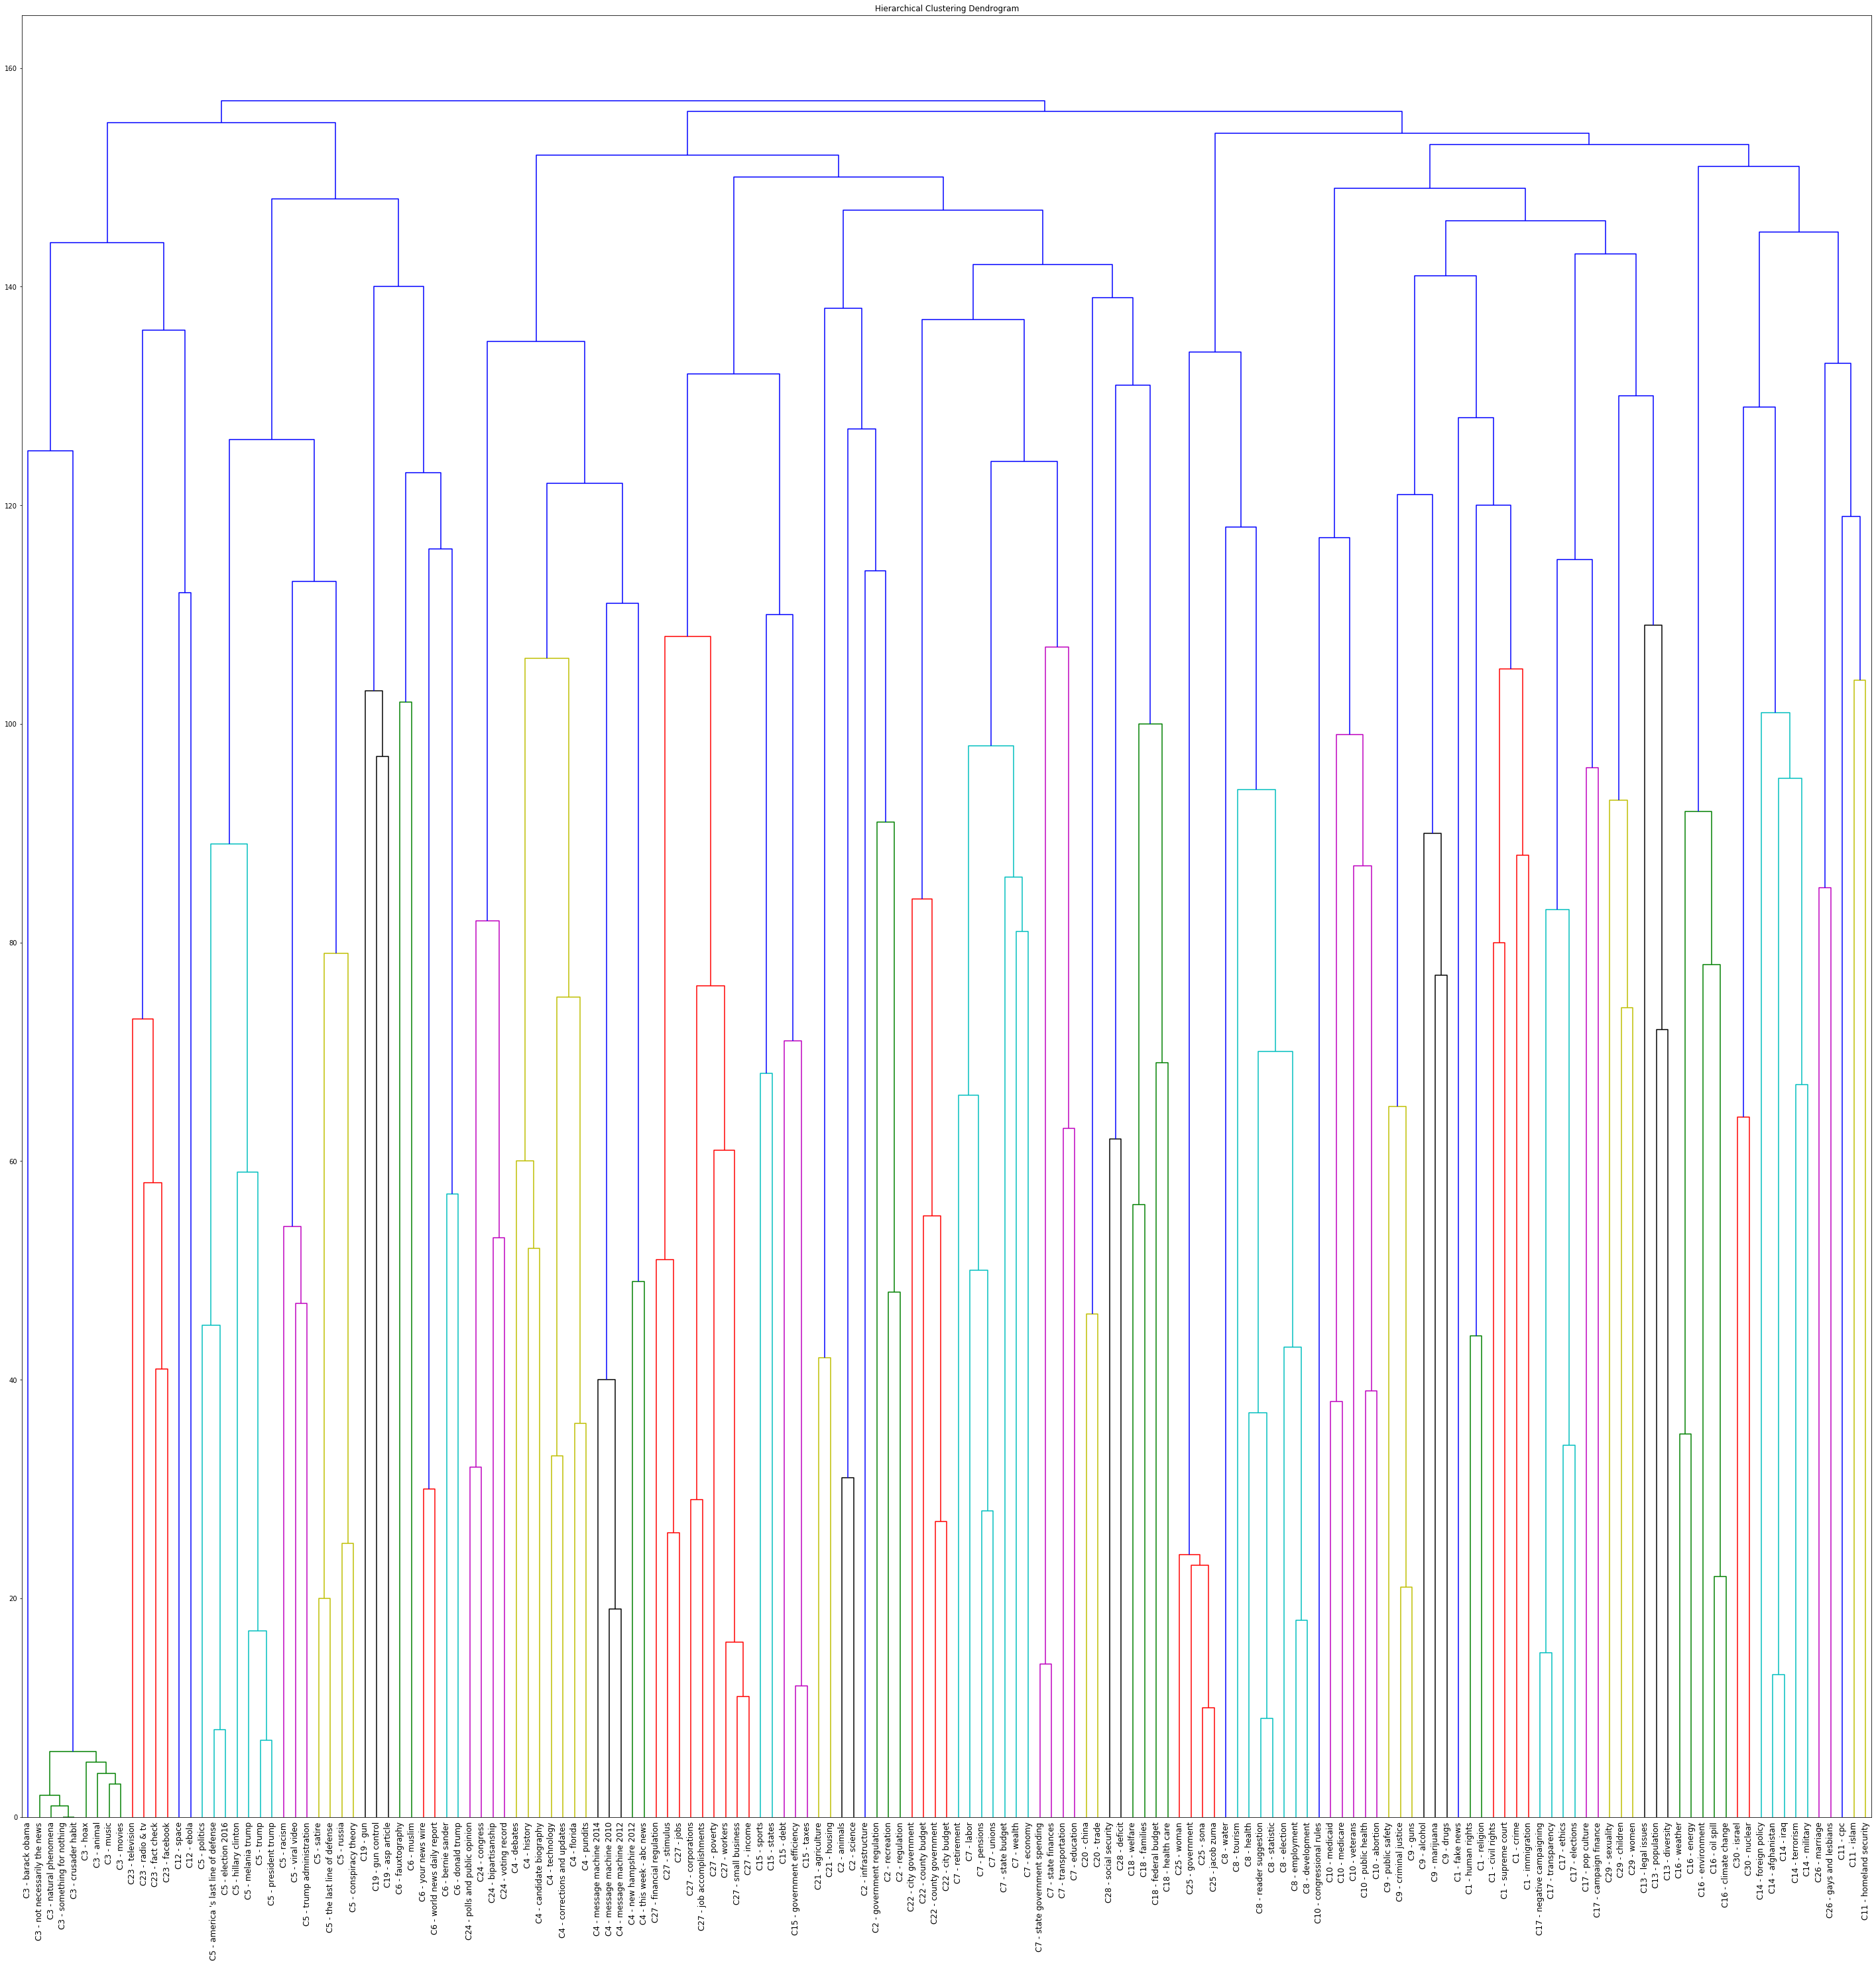

In [25]:
fig = plt.figure(figsize=(50,50))
plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(ward, labels=keywordList)
plot_dendrogram(ward, leaf_label_func=llf)
plt.show()

fig.savefig("Ward 30 Clusters.pdf", bbox_inches='tight')